# Generative Adversarial Network

<img src='https://camo.githubusercontent.com/4abfc46ad33ee9a0a34d8df7330f842dca7c3259b405cd5f1b8ef8f7aa958d6a/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313431362f312a367a4d5a424536787467475556716b614c5442614a512e706e67' width=50% />

## Thông tin học viên

- **Họ tên:** Trần Nguyên Huân
- **Mã số:** 21127050

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

## Mounting Google Drive in Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

## Define the GAN network

### Discriminator Network

In [92]:
# Discriminator Class Definition
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Initialize input and output features
        self.in_features = in_features
        self.out_features = out_features

        # First fully connected layer followed by LeakyReLU activation and dropout
        self.fc1 = nn.Linear(in_features=in_features, out_features=256)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout1 = nn.Dropout(0.3)

        # Second fully connected layer followed by LeakyReLU activation and dropout
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout2 = nn.Dropout(0.3)

        # Third fully connected layer followed by LeakyReLU activation
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)

        # Output layer to produce final decision
        self.fc4 = nn.Linear(in_features=64, out_features=out_features)

    def forward(self, x):
        # Reshape input to match batch size
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # Pass through the network layers with activations
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)

        # Compute the final decision logits
        logit_out = self.fc4(x)
        return logit_out

### Generator Network

In [97]:
# Generator Class Definition
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        # Initialize input and output features for the generator
        self.in_features = in_features
        self.out_features = out_features

        # First fully connected layer followed by LeakyReLU activation and batch normalization
        self.fc1 = nn.Linear(in_features=in_features, out_features=64)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.bn1 = nn.BatchNorm1d(64)

        # Second fully connected layer followed by LeakyReLU activation and batch normalization
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.bn2 = nn.BatchNorm1d(128)

        # Third fully connected layer followed by LeakyReLU activation and batch normalization
        self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.bn3 = nn.BatchNorm1d(256)

        # Output layer to produce the generated image, followed by Tanh activation
        self.fc4 = nn.Linear(in_features=256, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Sequentially pass input through layers with activations and batch normalization
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        # Apply Tanh to the final output to normalize it between -1 and 1
        tanh_out = self.tanh(x)
        return tanh_out

## Define the Losses Function

In [85]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Calculate loss for real images.
    
    Parameters:
    - predicted_outputs (Tensor): Discriminator predictions.
    - loss_fn (function): Loss function (e.g., BCELoss).
    - device (torch.device): CPU or GPU.
    
    Returns:
    - loss (Tensor): Loss for real images.
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.ones(batch_size, device=device)  # Labels: real images = 1
    loss = loss_fn(predicted_outputs.squeeze(), targets)
    return loss

def fake_loss(predicted_outputs, loss_fn, device):
    """
    Calculate loss for fake images.
    
    Parameters:
    - predicted_outputs (Tensor): Discriminator predictions.
    - loss_fn (function): Loss function (e.g., BCELoss).
    - device (torch.device): CPU or GPU.
    
    Returns:
    - loss (Tensor): Loss for fake images.
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size, device=device)  # Labels: fake images = 0
    loss = loss_fn(predicted_outputs.squeeze(), targets)
    return loss

## Loading and Preparing the MNIST Dataset

In [7]:
# location_path = '/content/drive/MyDrive/' + 'MNIST_FOR_GAN'
location_path = ''
# Define the transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
dataset = datasets.MNIST(root=location_path, transform=transform, download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3414110.08it/s]


Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 106051.09it/s]


Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1122256.00it/s]


Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw



### Visualize the dataset

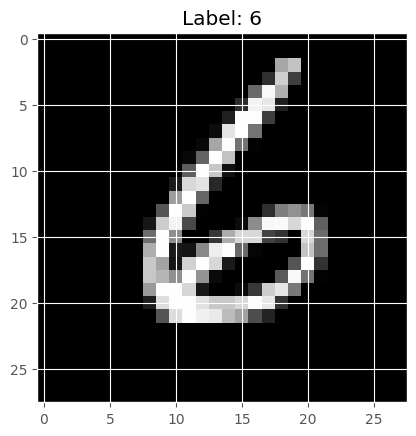

In [39]:
# Get a single batch of images
images, labels = next(iter(dataloader))

# Visualize the first image in the batch
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f'Label: {labels[0]}')
plt.show()

## Setting Device for PyTorch

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device', device)

Device cuda


## Generating and Visualizing Latent Vectors

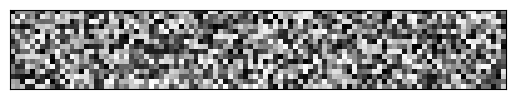

In [9]:
#Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Define the function train the model

In [90]:
def train_gan(discriminator, generator, d_optimizer, g_optimizer, loss_fn, dataloader, n_epochs, z_size, device):
    print(f'Training on [{device}]...')
    
    # Fixed latent vector for visualizing generator progress
    fixed_z = torch.from_numpy(np.random.uniform(-1, 1, size=(16, z_size))).float().to(device)
    fixed_samples = []
    d_losses = []
    g_losses = []

    # Move models to the specified device
    discriminator.to(device)
    generator.to(device)

    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        
        # Set models to training mode
        discriminator.train()
        generator.train()

        d_running_batch_loss = 0.0
        g_running_batch_loss = 0.0

        for curr_batch, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)

            ## Train Discriminator
            d_optimizer.zero_grad()
            
            # Convert real images from range [0, 1] to [-1, 1]
            real_images = (real_images * 2) - 1
            d_real_logits = discriminator(real_images)
            d_real_loss = loss_fn(d_real_logits, torch.ones_like(d_real_logits, device=device))

            # Generate fake images
            z = torch.from_numpy(np.random.uniform(-1, 1, size=(dataloader.batch_size, z_size))).float().to(device)
            with torch.no_grad():
                fake_images = generator(z)
            d_fake_logits = discriminator(fake_images)
            d_fake_loss = loss_fn(d_fake_logits, torch.zeros_like(d_fake_logits, device=device))

            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            d_running_batch_loss += d_loss.item()

            ## Train Generator
            g_optimizer.zero_grad()
            
            z = torch.from_numpy(np.random.uniform(-1, 1, size=(dataloader.batch_size, z_size))).float().to(device)
            fake_images = generator(z)
            g_logits = discriminator(fake_images)
            g_loss = loss_fn(g_logits, torch.ones_like(g_logits, device=device))
            
            g_loss.backward()
            g_optimizer.step()
            g_running_batch_loss += g_loss.item()

        # Calculate average epoch losses
        d_epoch_loss = d_running_batch_loss / len(dataloader)
        g_epoch_loss = g_running_batch_loss / len(dataloader)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        print(f'Epoch {epoch+1} - d_loss: {d_epoch_loss:.6f} \tg_loss: {g_epoch_loss:.6f}')

        # Generate fake images for visualization
        generator.eval()
        fixed_samples.append(generator(fixed_z).detach().cpu())

    # Save generated samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses

## Model hyperparameters

### Initializing Discriminator and Generator Models

In [98]:
# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
print(d)
print('\n')
print(g)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (bn3): Ba

### Setting Up Optimizers and Loss Function

In [99]:
# Instantiate optimizers
d_optimizer = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

### Training the GAN Model

In [100]:
#Train
z_size = 100
n_epochs = 150
d_losses, g_losses = train_gan(d, g, d_optimizer, g_optimizer, loss_fn, dataloader, n_epochs, z_size, device)

Training on [cuda]...
Epoch [1/150]:
Epoch 1 - d_loss: 0.496698 	g_loss: 2.516644
Epoch [2/150]:
Epoch 2 - d_loss: 0.828961 	g_loss: 1.567806
Epoch [3/150]:
Epoch 3 - d_loss: 0.906770 	g_loss: 1.452913
Epoch [4/150]:
Epoch 4 - d_loss: 0.975557 	g_loss: 1.359883
Epoch [5/150]:
Epoch 5 - d_loss: 1.023425 	g_loss: 1.275246
Epoch [6/150]:
Epoch 6 - d_loss: 1.054188 	g_loss: 1.220833
Epoch [7/150]:
Epoch 7 - d_loss: 1.090055 	g_loss: 1.161065
Epoch [8/150]:
Epoch 8 - d_loss: 1.123431 	g_loss: 1.093447
Epoch [9/150]:
Epoch 9 - d_loss: 1.147208 	g_loss: 1.056895
Epoch [10/150]:
Epoch 10 - d_loss: 1.169271 	g_loss: 1.020656
Epoch [11/150]:
Epoch 11 - d_loss: 1.179859 	g_loss: 1.006841
Epoch [12/150]:
Epoch 12 - d_loss: 1.178947 	g_loss: 1.001854
Epoch [13/150]:
Epoch 13 - d_loss: 1.191508 	g_loss: 0.986638
Epoch [14/150]:
Epoch 14 - d_loss: 1.191234 	g_loss: 0.981971
Epoch [15/150]:
Epoch 15 - d_loss: 1.201807 	g_loss: 0.970743
Epoch [16/150]:
Epoch 16 - d_loss: 1.199757 	g_loss: 0.966927
Epoc

## Evaluate the loss function

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

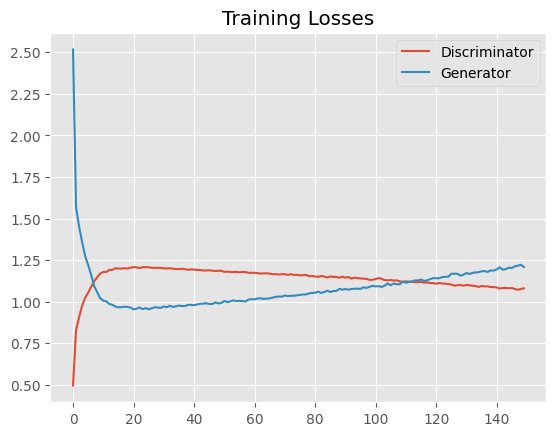

In [101]:
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.title("Training Losses")
plt.show()

In [102]:
def show_image(images, n_cols=4, figsize=(12, 6)):
    """
    Display a collection of images in a grid.

    Parameters:
    - images (Tensor): Tensor of shape (batch_size, channels, height, width) containing images.
    - n_cols (int): Number of columns in the grid.
    - figsize (tuple): Size of the figure.

    Returns:
    - None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        image = images[idx].detach().permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis  # Set colormap for grayscale or color
        ax.imshow(image, cmap=cmap)
        ax.axis('off')  # Hide axes ticks
    
    plt.tight_layout()
    plt.show()

In [108]:
def view_images(epoch, n_cols=8):
    # load saved images
    with open('train_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    show_image(images=image_batch, n_cols=n_cols, figsize=(12, 4))

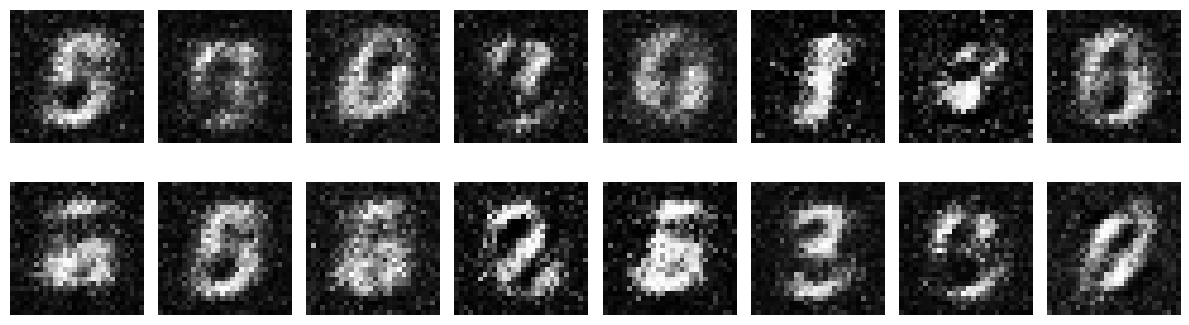

In [109]:
view_images(epoch=1, n_cols=8)

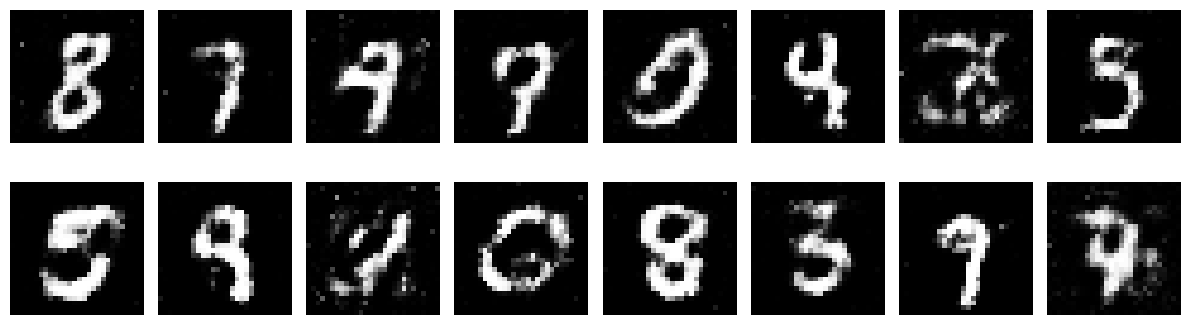

In [110]:
view_images(epoch=10, n_cols=8)

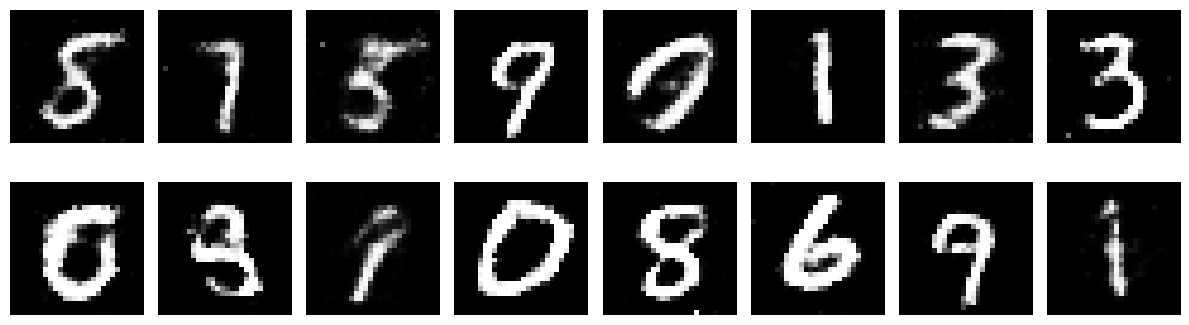

In [111]:
view_images(epoch=50, n_cols=8)

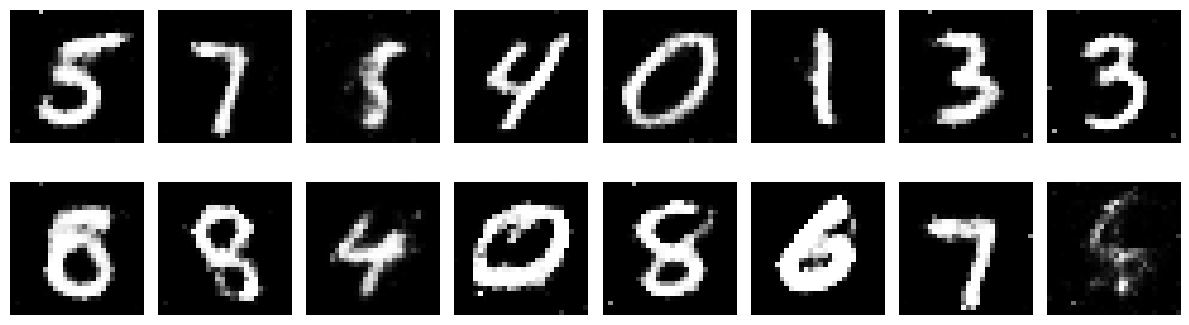

In [112]:
view_images(epoch=100, n_cols=8)

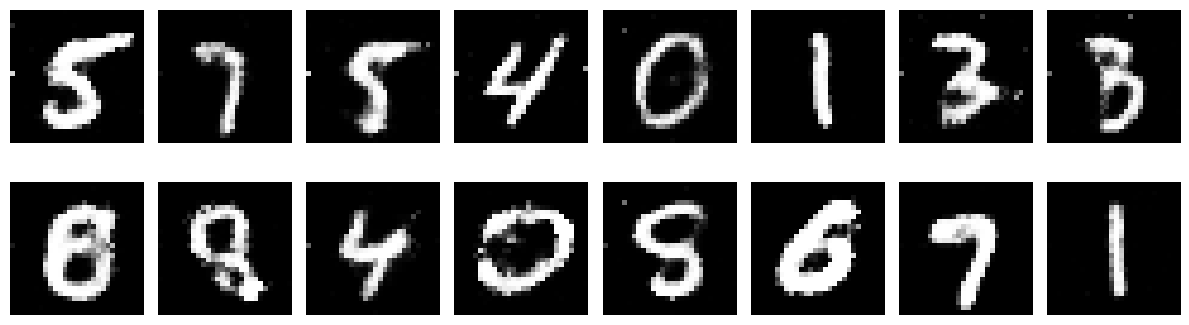

In [113]:
view_images(epoch=150, n_cols=8)

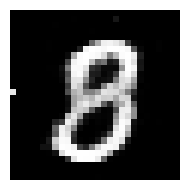

In [136]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
show_image(fake_image, n_cols=1, figsize=(2, 2))

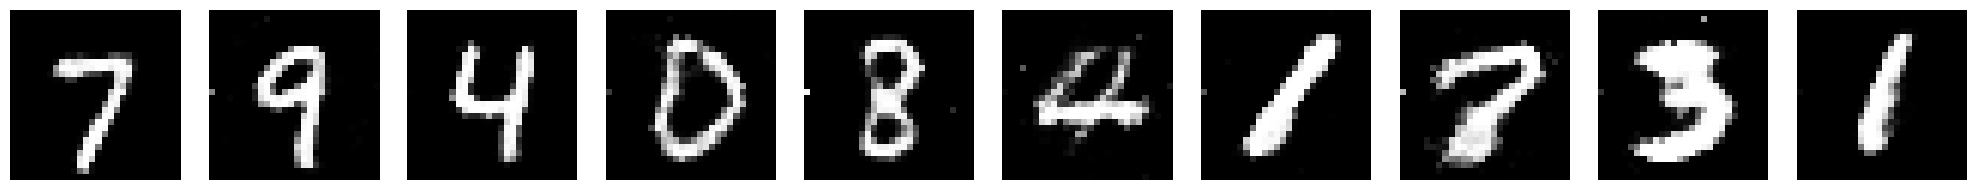

In [150]:
def generate_and_show_images(generator, n_images=5, z_size=100):
    """
    Generate and display fake images using a trained generator.

    Parameters:
    - generator (nn.Module): The trained generator model.
    - n_images (int): Number of images to generate.
    - z_size (int): Size of the latent vector.

    Returns:
    - None
    """
    images = []

    for _ in range(n_images):
        # Generate a random latent vector
        z = np.random.uniform(-1, 1, size=(1, z_size))
        z = torch.from_numpy(z).float()

        # Generate a fake image
        with torch.no_grad():
            fake_image = generator(z)

        # Reshape for display
        fake_image = fake_image.view(1, 1, 28, 28).detach()
        images.append(fake_image)

    # Display images
    images = torch.cat(images)
    show_image(images, n_cols=n_images, figsize=(n_images * 2, 2))

# Example usage
generate_and_show_images(g, n_images=10, z_size=100)

## References

[1] [Paper - Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)

[2] [File PDF PRACTICE #02 (GAN) – LQN](https://courses.fit.hcmus.edu.vn/pluginfile.php/207958/mod_resource/content/1/K33_ACV_2024_LQN_P02.pdf)

[3] [Giới thiệu về GAN](https://nttuan8.com/bai-1-gioi-thieu-ve-gan/)

[4] [Studying-the-Robustness-of-GANs-on-Noisy-Data-using-MNIST-and-EMNIST-Datasets](https://github.com/SuchismitaSahu1993/Studying-the-Robustness-of-GANs-on-Noisy-Data-using-MNIST-and-EMNIST-Datasets)